#### _Speech Processing Labs 2020: Module 2_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import cmath
from math import floor
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('ggplot')

from dspMisc import *

# 2 Filtering the Source: Finite Impulse Response Filters 

### Learning Outcomes
* Be able to describe what an FIR filter is
* Be able to explain what the impulse response of an FIR filter is
* See how an FIR filter can be used as a lowpass frequency filter.
* See how changing the coefficients of an FIR filter can change it's frequency response

### Need to know
* Topic Videos: Spectral Envelope, Filter, Impulse Train
* Discrete Fourier Transform


## 2.0 Filters 

We've seen in the past notebooks that sometimes our input signal isn't exactly what we want. There is a vast literature in signal processing about designing filters to transform one signal into another. In speech processing, our signals often includes some sort of noise that we'd like to get rid of.  However, we can also use filters to shape a simple input, like an impulse train, into something much more complicated, like a speech waveform. 

In class you've seen two types of filters: 

* Finite Impulse Response (FIR)
* Infinite Impulse Response (IIR)

Both perform a transform on an input sequence $x[n]$ to give us some desired output sequence $y[n]$.  The difference between the two types of filters is basically whether we only use the inputs to derive each output $y[n]$ (FIR), or whether we also use previous outputs (IIR). 

In the following we'll illustrate some of the properties of FIR filters. 

## 2.1  Finite Impulse Response Filters

Finite Impulse Response (FIR) filters have the following form: 

$$
\begin{align}
y[n] &= b[0]x[n] + b[1]x[n-1] + \dots + b[K]x[n-K] \\
 &= \sum_{k=0}^K b(k) x[n-k]
\end{align}
$$

Here, we have: 
* an input sequence $x[n]$ of length $N$
* a set of $K$ filter coefficients.

We can read the equation as saying that $n$th ouput of the filter, $y[n]$, is a weighted sum of the previous K inputs $x[n],...,x[n-K]$.  

### Example
Let's plot the $b[k]*x[n-k]$ terms where $x$ is sinusoid of 4 Hz and the filter is `b=[1.1, 1.2, 1.5, 1.2, 1.1]`

sampling rate: f_s = 64.000000
sampling time: t_s: 0.015625
filter using b at n=19, K=5

19:, b[0]=1.100000, x[19-0]=0.382683, b[0]*x[19-0]=0.420952
18:, b[1]=1.200000, x[19-1]=0.707107, b[1]*x[19-1]=0.848528
17:, b[2]=1.500000, x[19-2]=0.923880, b[2]*x[19-2]=1.385819
16:, b[3]=1.200000, x[19-3]=1.000000, b[3]*x[19-3]=1.200000
15:, b[4]=1.100000, x[19-4]=0.923880, b[4]*x[19-4]=1.016267

y[19] = 4.871567


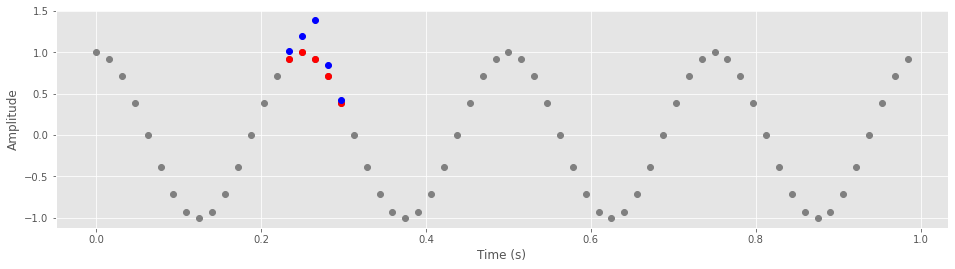

In [2]:
## Plotting a filter input window

## Set the number of samples N, sampling rate f_s
N=64
f_s = 64
t_s = 1/f_s
print("sampling rate: f_s = %f\nsampling time: t_s: %f" % (f_s, t_s))

x, time_steps = gen_sinusoid(frequency=4, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)

## Plot the sinusoid we've just created:
fig, timedom = plt.subplots(figsize=(16, 4))
timedom.plot(time_steps, x, 'o', color='grey')
timedom.set_xlabel('Time (s)')
timedom.set_ylabel('Amplitude')

## Filter coefficients (you could try changing these)
b = [1.1, 1.2, 1.5, 1.2, 1.1]

## K is the number of filter coefficients
K=len(b)

## Let's see what happens when n=19 (or try changing this variable!)
n=19
print("filter using b at n=%d, K=%d\n" % (n, K))

## Plot the values that are input to the filter
## +1's because python indexing/slicing doesn't include the end point
timedom.plot(time_steps[n+1-K:n+1], x[n+1-K:n+1], 'o', color='red')

## Calculate the b[k]*x[n-k] terms and add them to a list
filtered_n = []
for k in range(len(b)):
    ## print out the variables here
    print("%d:, b[%d]=%f, x[%d-%d]=%f, b[%d]*x[%d-%d]=%f" % (n-k, k, b[k], n, k,  x[n-k], k, n, k, b[k]*x[n-k]))
    filtered_n.append(b[k]*x[n-k])
 
## reverse the list so that they're in time order
filtered_n.reverse()    

## Plot the b[k]*x[n-k] terms
timedom.plot(time_steps[n+1-K:n+1], filtered_n, 'o', color='blue')

## Calculate the filter output (add up the product terms)
print("\ny[%d] = %f" % (n, sum(filtered_n)))

In the plot above, you should see:
* A cosine wave with frequency 4 Hz in grey.  
* The inputs the the filter x[19],...,x[15] in red.  
    * 5 input values for 5 filter coefficients
* The product $b[k]*x[n-k]$ for $n=19$, and $k=0,...,4$

So with `b = [1.1, 1.2, 1.5, 1.2, 1.1]` all the input values get scaled up, with the the middle of the filter window get biggest relative increase.

When we add all the product terms together, we get y[19] = 4.87 - a lot bigger than any of the input values! 

## 2.2 An FIR moving average filter

A useful special case of an FIR filter is where each of the filter coefficients is just $1/K$. In this case our FIR equation looks like this: 

 $$ 
 \begin{align}
     y[n] &= \sum_{k=0}^{K-1} \frac{1}{K} x[n-k] \\
          &= \frac{1}{K} \sum_{k=0}^{K-1}  x[n-k] 
 \end{align}
 $$

This equation says that when we apply the filter, we step through the input. At each step, we output the average of the previous $K$ inputs. You might know this by another more intuitive name: a _moving average_.  You might also have seen this as method to 'smooth' an input.  

Let's play around with this idea a bit and see how it relates to our notion of frequency response.


### Example: 

Let's look at this 5-point moving average filter.  In this case all the filter coefficients $b[k] = 1/5$ for $k=0,..,K-1=4$

$$ 
\begin{align}
y[n] &= \frac{1}{5} \sum_{k=0}^4 x[n-k] \\
&= \frac{1}{5}x[n] + \frac{1}{5}x[n-1] + \frac{1}{5}x[n-2] + \frac{1}{5}x[n-3] + \frac{1}{5}x[n-3]
\end{align}
$$

Now, let's code this specific filter up and apply it to some sequences! 


In [4]:
# Apply a moving average filter of size K to input sequence x
def moving_average(x, K=5):
    ## There are quicker ways to do this in numpy, but let's just do it this way for now for transparency
    
    ## We know that we'll have as many outputs as inputs, so we can initialize y to all zeros
    N = len(x)    
    y = np.zeros(N)
    
    ## Go through the input one step at a time 
    for n in range(N):
        
        ## Add up the last K inputs (including the current one)
        for k in range(K):
            
            ## Exercise: why do we have to put this conditional in here? 
            if n-k >= 0:
                y[n] = y[n] + x[n-k]
        
        ## Divide by the size of the input window to get an average
        y[n] = (1/K) * y[n]

    return y
        
    


### Generate a 'noisy' sinusoid

Let's generate a compound sinusoid with one low frequency and one high(er) frequency component.  We can take the higher frequency component as representing some sort of periodic noise in the signal.

In [5]:
## Set the number of samples N, sampling rate f_s
N=64
f_s = 64
t_s = 1/f_s

print("sampling rate: f_s = %f\nsampling time: t_s: %f" % (f_s, t_s))

sampling rate: f_s = 64.000000
sampling time: t_s: 0.015625


In [6]:
## make some sinusoids: 
## Since the sample rate and sequence length is the same, the generated time steps will match for 
## x1 and x2
x1, time_steps = gen_sinusoid(frequency=4, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)
x2, time_steps = gen_sinusoid(frequency=24, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)

# add them up!
x_noisy = x1 + x2

Text(0, 0.5, 'Amplitude')

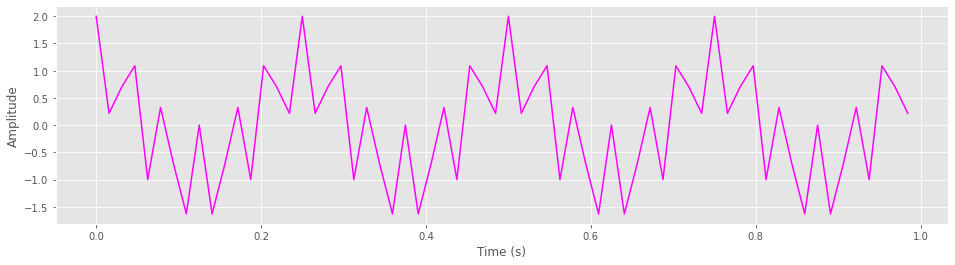

In [7]:
## Plot the compound sinusoid we've just created:
fig, timedom = plt.subplots(figsize=(16, 4))
timedom.plot(time_steps, x_noisy, color='magenta')
timedom.set_xlabel('Time (s)')
timedom.set_ylabel('Amplitude')

You should be able to see that the 4Hz cosine wave is perturbed by a 24 Hz cosine. So, this could represent a situation where there is high frequency noise in our signal that we'd like to get rid of.  Let's see if we can use our filter to smooth out this high frequency noise. 


### Apply the moving average filter

In [8]:
## Apply our moving average filter
K=5
y_mov = moving_average(x_noisy,K=K)

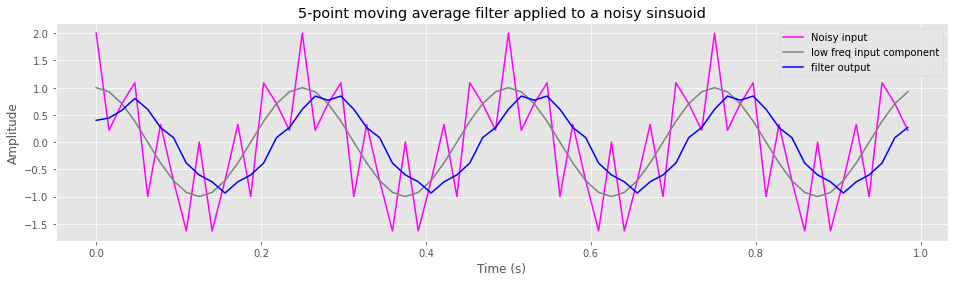

In [9]:
## Plot the results
fig, timedom = plt.subplots(figsize=(16, 4))
timedom.set_xlabel('Time (s)')
timedom.set_ylabel('Amplitude')

## The input signal
timedom.plot(time_steps, x_noisy, color='magenta', label='Noisy input')

## The underlying 4Hz signal
timedom.plot(time_steps, x1, color='grey', label='low freq input component')

## After the moving average has been applied
timedom.plot(time_steps, y_mov, color='blue', label='filter output')

timedom.set_title('%d-point moving average filter applied to a noisy sinsuoid' % K)
timedom.legend()

You should see: 
* the original signal in magenta
* the low frequency cosine component in grey
* the output of the filter in blue

### Exercise: 

* From the plot, does it appear that the moving average recovered the original 4Hz signal in terms of:
    * frequency?
    * amplitude?
    * phase?
* Are there still high frequency components in the filter output? 

Can you see some issues with applying this filter? What happens at the end points? Are they valid? 

### Notes

### Get the DFT of the filtered signal

We can apply the DFT to our output to check our observations from the time-domain output. 

In [10]:
## DFT of the original input
mags_x, phases_x = get_dft_mag_phase(x_noisy, N)

## DFT of the filter output
mags_y, phases_y = get_dft_mag_phase(y_mov, N)

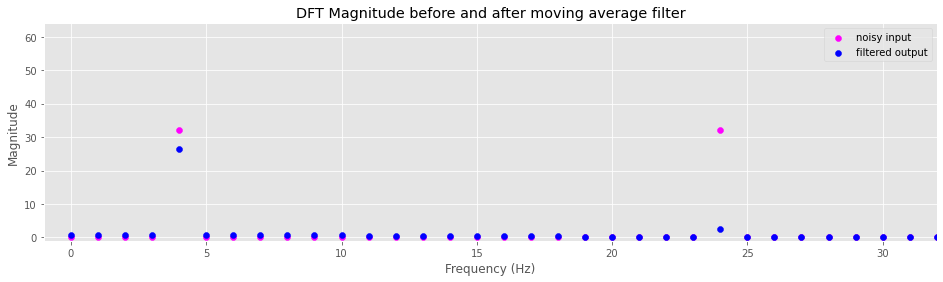

In [12]:
dft_freqs = get_dft_freqs_all(sample_rate=f_s, seq_len=N)

fig, mags = plt.subplots(figsize=(16, 4))
mags.set(xlim=(-1, N/2), ylim=(-1, N))
mags.scatter(dft_freqs, mags_x, color='magenta', label='noisy input')
mags.scatter(dft_freqs, mags_y, color='blue', label='filtered output')
mags.set_xlabel("Frequency (Hz)")
mags.set_ylabel("Magnitude")
mags.set_title("DFT Magnitude before and after moving average filter")
mags.legend()

#Let's not worry about phase right now, but feel free to uncomment and have a look! 
#fig, phases = plt.subplots(figsize=(16, 4))
#phases.set(xlim=(-1, N/2), ylim=(-10, 10))
#phases.scatter(dft_freqs, phases_x, color='magenta', label='noisy input')
#phases.scatter(dft_freqs, phases_y, color='blue', label='filtered output')
#phases.set_xlabel("Frequency (Hz)")
#phases.set_ylabel("Phase (rad)")
#phases.set_title("DFT Phase before and after moving average filter")
#phases.legend()


### Exercise

* Based on the magnitude spectrum: 
    * Did the filter get rid of the 24Hz component? 
    * Do you see any signs of leakage? 
 
    
* What happens if you change the frequency of the second sinusoid to something lower (e.g. 6Hz)? 

### Notes

## 2.3 FIR as convolution

An FIR Filter that takes $m$ previous elements of $x[n]$ as input has the following general form: 

$$ y[n] = \sum_{k=0}^{K-1} b[k] x[n-k] $$ 

You might recognize this as a **convolution** of the two sequences $b$ and $x$  (i.e. $b * x$).

So, we can theoretically set our filter to coefficients to whatever we want.  Here's a function that generalizes our moving average filter to allow for this:

In [13]:
def fir_filter(x, filter_coeffs):
    N = len(x)
    K = len(filter_coeffs)
    
    y = np.zeros(N)   
    for n in range(N):
        for k in range(K):
            if n-k >= 0: 
                #print("y[%d]=%f, b[%d]=%f, x[%d]=%f" % (n, y[n], k, filter_coeffs[k], n-k, x[n-k]))
                y[n] = y[n] + (filter_coeffs[k]*x[n-k])
        #print("y[%d]=%f" % (n, y[n]))
    return y    
    

### Changing the filter coefficients

Let's try it out with different coefficient values, comparing our unweighted average `h_avg` filter with a weighted average `h_wavg` filter. 

In [14]:

## The 5-point moving average from before
h_avg = np.array([1/5, 1/5, 1/5, 1/5, 1/5])
y_avg = fir_filter(x_noisy, h_avg)

## A 5-point symmetrically weighted average 
h_wavg = np.array([1/5, 1/3, 1, 1/3, 1/5])
y_wavg = fir_filter(x_noisy, h_wavg)

### Filter effects in the time domain

Text(0, 0.5, 'Amplitude')

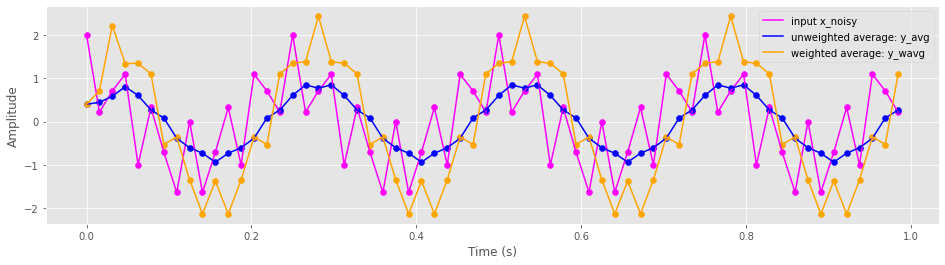

In [15]:
## Plot the filter outputs
fig, timedom = plt.subplots(figsize=(16, 4))

## The original "noisy" input
timedom.plot(time_steps, x_noisy, color='magenta', label='input x_noisy')
timedom.scatter(time_steps, x_noisy, color='magenta')

## The 5-point moving average
timedom.plot(time_steps, y_avg, color='blue', label='unweighted average: y_avg')
timedom.scatter(time_steps, y_avg, color='blue')

## The 5-point weighted average
timedom.plot(time_steps, y_wavg, color='orange', label='weighted average: y_wavg')
timedom.scatter(time_steps, y_wavg, color='orange')
timedom.legend()
timedom.set_xlabel('Time (s)')
timedom.set_ylabel('Amplitude')

In this time vs amplitude graph, you should see:
* the 'noisy input' in magenta
* the output of the unweighted average filter in blue (`y_avg`)
* the output of the weighted average filter in orange (`y_wavg`)

### Exercise

Q: Why is the output of `y_wavg` more spikey than that of `y_avg`?


### Notes

## 2.4 FIR Filters in the Frequency Domain


### The DFT of the filtered outputs

We can look at the effect of the two FIR filters defined above in the frequency domain by performing a DFT on the filter outputs. 


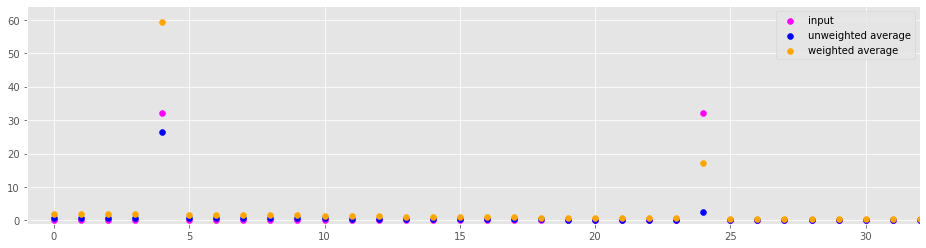

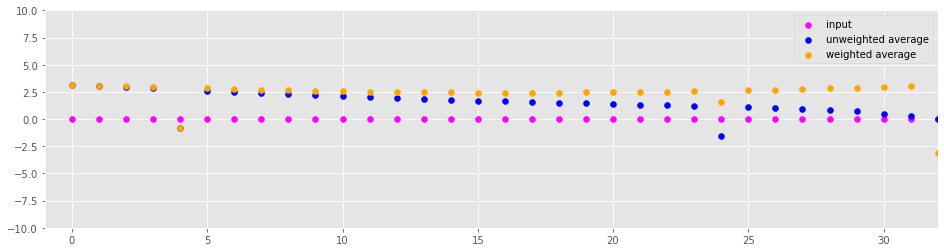

In [16]:
## DFT of the original input
mags_x, phases_x = get_dft_mag_phase(x_noisy, N)

## DFT after weighted average filter: h_wavg = np.array([1/5, 1/3, 1, 1/3, 1/5])
mags_wavg, phases_wavg = get_dft_mag_phase(y_wavg, N)

## DFT after unweighted average filter: h_avg = np.array([1/5, 1/5, 1/5, 1/5, 1/5])
mags_avg, phases_avg = get_dft_mag_phase(y_avg, N)

dft_freqs = get_dft_freqs_all(sample_rate=f_s, seq_len=N)

## Plot magnitude spectrums
fig, mags = plt.subplots(figsize=(16, 4))
mags.set(xlim=(-1, N/2), ylim=(-1, N))
mags.scatter(dft_freqs, mags_x, color='magenta', label='input')
mags.scatter(dft_freqs, mags_avg, color='blue', label='unweighted average')
mags.scatter(dft_freqs, mags_wavg, color='orange', label='weighted average')
mags.legend()

## Plot phase spectrums
fig, phases = plt.subplots(figsize=(16, 4))
phases.set(xlim=(-1, N/2), ylim=(-10, 10))
phases.scatter(dft_freqs, phases_x, color='magenta', label='input')
phases.scatter(dft_freqs, phases_avg, color='blue', label='unweighted average')
phases.scatter(dft_freqs, phases_wavg, color='orange', label='weighted average')
phases.legend()


### Exercise: 

* Describe the difference between the different FIR filters based on the frequency magnitude and phases responses plotted above. 

* Does the weighted average filter do as good a job at filtering out the higher frequency signals? 



### Notes


## 2.5 Convolution in Time,  Multiplication in Frequency 


Now we get to the really cool bit.  We know that the DFT allows us to go from the time domain to the frequency domain (and the Inverse DFT let's us go back).  But it also has this very important property: 

$$ h[k] * x[n] \mapsto \text{ DFT} \mapsto H(m) \cdot X(m) $$




That is, convolving an input sequence $x$ with a set of filter coefficients, $h$ in the time domain  ($h*x$) is the same as (pointwise) multiplication of the DFT of $h$ with the DFT of $x$.  So, if we know what type of frequency $h$ has, we can treat this as apply a sort of mask to the DFT of $x$.  This property is known as the **convolution theorem**. 

Another way to think about it is that if the DFT outputs of $h$ has zero magnitude, then applying that filter to some input will also zero out those frequencies in the filter output! 

We'll see some visualizations of this shortly, but first, we can also note that you can go back the other way using the Inverse DFT: 

$$ H(m) \cdot X(m) \mapsto \text{ IDFT} \mapsto h[k] * x[n] $$


And also it works for multiplication in time domain too: 

$$ h[k] \cdot x[n] \mapsto \text{DFT} \mapsto H(m) * X(m) $$

This is useful for understanding why the leakage graph around each DFT bin looks the way it does (though we won't go into it here!). 

In fact, we can use this to not only show that the moving average acts as a low pass filter, but also to be able to calculate exactly the type of filter it will be. 

###  Plotting different FIR filter frequency responses

In order to multiply together the filter and the input frequency responses, we need to make sure the filter and the input have the same number of samples.  We can do this by just padding out the filter with zeros (you can see why in the optional extra material at the end of this notebook).  We can then look how changing the 'shape' of a filter changes it's frequency response. The following exercise shows some examples. 

### Exercise
* Run the function plot_filter_freq_responses (defined in the next cell) to plot the frequency responses of filters with different shapes (e.g. `h_plat`, `h_tri`, `h_rect` in the cell below the next).  
    * What's the difference in frequency response of the triangular filter and the rectangular filter? 
    * What's the difference between the moving average of size 5 and one of size 9 (h_rect9)? 
    * Try some other FIR filters! 

In [17]:
# Given a list of filters, the sample rate and a specific sequence length
# plot the DFT frequency response of each filter.
# Each filter should be defined as a list of coeffients (b[k])
def plot_filter_freq_responses(filters, sample_rate, seq_length):

    ## Get the set of DFT output frequencies given the sample rate and desired sequence length
    dft_freqs_filter = (sample_rate/seq_length) * np.arange(seq_length)
    
    ## Calculate the time steps for each filter value given the sample rate and sequence length
    time_steps = (1/sample_rate) * np.arange(seq_length)
    
    ## Set up some plots:
    # the filter itself (time v amplitude)
    fig_time, sinusoid = plt.subplots(figsize=(16, 4))
    
    # the frequency response (freq v magnitude)
    fig_freq, fresponse = plt.subplots(figsize=(16, 4))
  
    x_filters = {}
    ## For each filter: 
    for i, h in enumerate(filters): 
        
        # pad the filter coefficients with zeros until we get the desired sequence length
        x_zeros = np.zeros(seq_length - len(h))
        x = np.concatenate([h, x_zeros])
        
        # Get the DFT outputs
        mags, phases = get_dft_mag_phase(x, seq_length)
        
        # Plot the filter
        sinusoid.scatter(time_steps, x)
        sinusoid.plot(time_steps, x, label=repr(h))

        # plot the magnitude response
        fresponse.scatter(dft_freqs_filter, mags)
        fresponse.plot(dft_freqs_filter, mags, label=repr(h))
        fresponse.set(xlim=(-1,seq_length/2))
        
        # return the filters and the DFT responses just in case
        x_filters = {'x':x, 'mags':mags, 'phases':phases, 'coeffs':h}

    sinusoid.set_xlabel('Time(s)')
    sinusoid.set_ylabel('Amplitude')
    sinusoid.set_title('Zero padded filters of different shapes')
    sinusoid.legend() 
    
    fresponse.set_xlabel('Frequency (Hz)')
    fresponse.set_ylabel('Magnitude')
    fresponse.set_title('DFT magnitude response of ero padded filters of different shapes')
    fresponse.legend()
    
    return x_filters


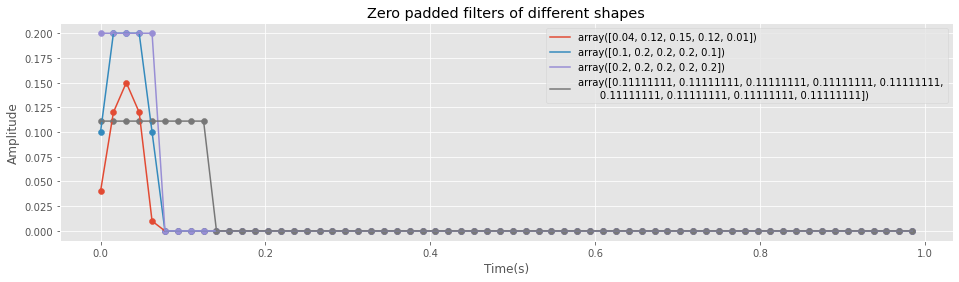

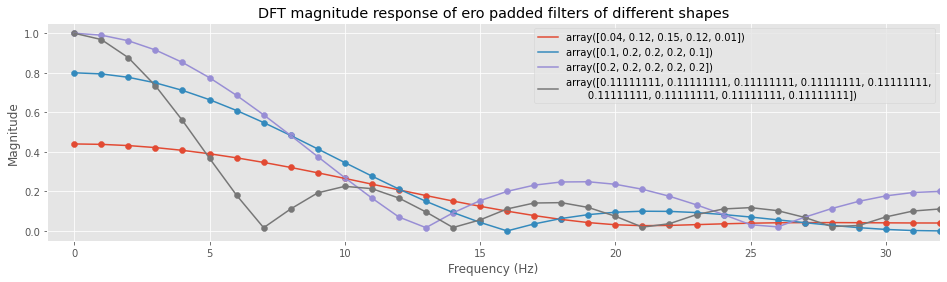

In [18]:
h_plat = np.array([0.1, 0.2, 0.2, 0.2, 0.1])
h_tri = np.array([0.04, 0.12, 0.15, 0.12, 0.01])
h_rect = np.array([1/5, 1/5, 1/5, 1/5, 1/5])
h_rect9 = np.array([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
## Try some others if you like!

N=64
f_s=64

filter_dict = plot_filter_freq_responses(filters=[h_tri, h_plat, h_rect, h_rect9], sample_rate=f_s, seq_length=N)

### Notes



## 2.7 Applying an FIR filter to an impulse train

Now, finally we can look at the effect of applying an FIR filter to an impulse train.  Remember, we're using impulse trains to represent a sound source (i.e. vocal pulses at a specific frequency).  Eventually, we want to be able to define filters that capture the effects of the vocal tract.  

First, here's a function that produces a sequence of pulses at a given frequency and sample rate. We'll then apply a triangular filter and look at what the frequency response is of the output is. 

In [19]:
## Let's make an impulse train
N=200
f_s = 8000
t_s = 1/f_s

frequency = 200

x_imp, time_steps = make_impulse_train(sample_rate=f_s, frequency=frequency, n_samples=N)


Text(0.5, 1.0, 'Impulse train')

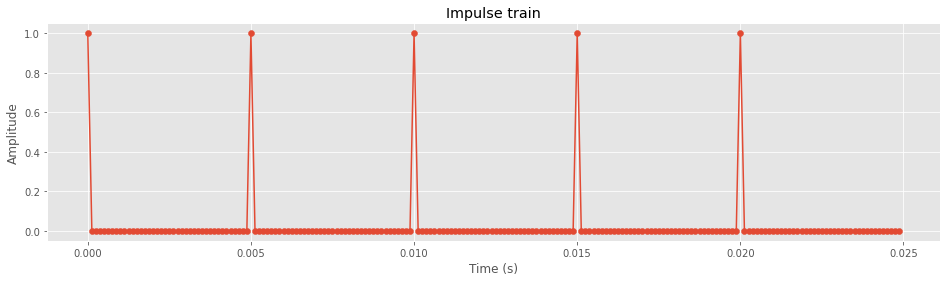

In [20]:
## Plot the impulse train made in the cell before
fig, td = plt.subplots(figsize=(16, 4))
td.scatter(time_steps, x_imp)
td.plot(time_steps, x_imp)
td.set_xlabel('Time (s)')
td.set_ylabel('Amplitude')
td.set_title('Impulse train')

You should see an impulse train, with an impulse frequency of 200 Hz.  Let's see what happens when we apply the filter. 

Text(0.5, 1.0, 'Impulse train and filtered impulse train')

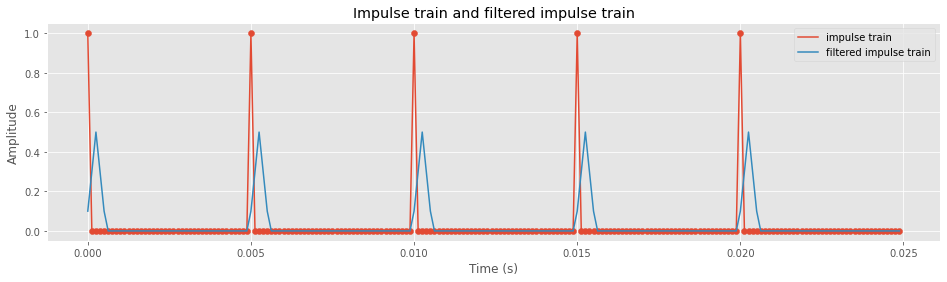

In [21]:
## define our FIR filter coefficients
h_mov = np.array([0.1, 0.3, 0.5, 0.3, 0.1])

#try this later!
#h_mov = np.array([1])


## Apply the filter to our impulse train
y_mov = fir_filter(x_imp, h_mov)

## plot the impulse train and the filtered version of it
fig, td = plt.subplots(figsize=(16, 4))
td.scatter(time_steps, x_imp)
td.plot(time_steps, x_imp, label='impulse train')
td.plot(time_steps, y_mov, label='filtered impulse train')
td.set_xlabel('Time (s)')
td.set_ylabel('Amplitude')
td.legend()
td.set_title('Impulse train and filtered impulse train')

Here you should see our impulse train (red) and the filtered impulse train (blue).  The filtered version has smaller amplitude and a broader peak (more samples have non-zero value).  Also, the filtered peaks are slightly after the original impulses. 

Now let's look at the DFT output: 

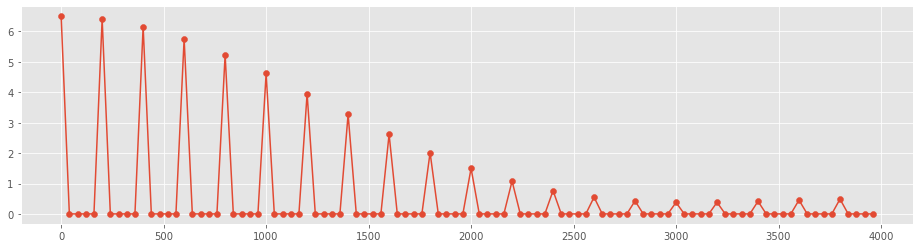

In [22]:
## Get the DFT the filter output
mags, phases = get_dft_mag_phase(y_mov, N)

## Plot the DFT frequencies rather than DFT output indices
dft_freqs = get_dft_freqs_all(f_s, N)

## Plot the magnitude spectrum
fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(dft_freqs[0:int(N/2)],mags[0:int(N/2)])
ax.plot(dft_freqs[0:int(N/2)], mags[0:int(N/2)])


### Exercises

* What do the spikes in the DFT outputs represent? 
* What does the first spike after the 0 frequency one represent? 
* What does this filter appear to do?
    * Remember applying the FIR filter in the time domain (via convolution) is the same as multiplying the DFT of the filter to the DFT of the input signal

### Notes

### Exercises 

* What happens when the impulse train frequency doesn't fall on one of the bins? e.g. `frequency = 130`, for 200 samples, with sampling rate 8000 samples/second
* Does the magnitude spectrum have the harmonic structure you'd expect? 

### Notes

## 2.6 (Extra Extension) The moving average filter as a rectangular function

<div class="alert alert-warning">
<em>This section (2.6) illustrates how we can use the convolution theorem understand why the moving average type filters act like low pass filters, and also the connection with leakage in the DFT magnitude response we saw previously.  This is optional extra material. 
    

If you want to see an example of the convolution theorem working in the frequency domain, you can just run the code and have a look at the graph titled 'Frequency response after applying 5-point weighted average filter'</em>
</div>

The convolution theorem tells us that, if we know the frequency response of an FIR filter, we know how it will affect the frequency response of it's input (we just multiply the individual frequency response together). 

To understand what filter frequency response will look like, it's helpful to first observe that our unweighted moving average filter is pretty much a rectangular window function.  It's easy to see what this means  rectangular we plot it. The following function allows us to generate rectangular functions:

In [23]:
def gen_rect_window(start_index, end_index, sample_rate=64, seq_length=64): 
    nsteps = np.array(range(seq_length))
    t_s = 1/sample_rate
    time_steps = t_s * nsteps

    ## Let's make a rectangular window
    x_rect = np.zeros(seq_length)
    x_rect[start_index:end_index] = 1
    
    return x_rect, time_steps


###  Now, we make a rectangular window

Text(0.5, 1.0, 'a rectangular window')

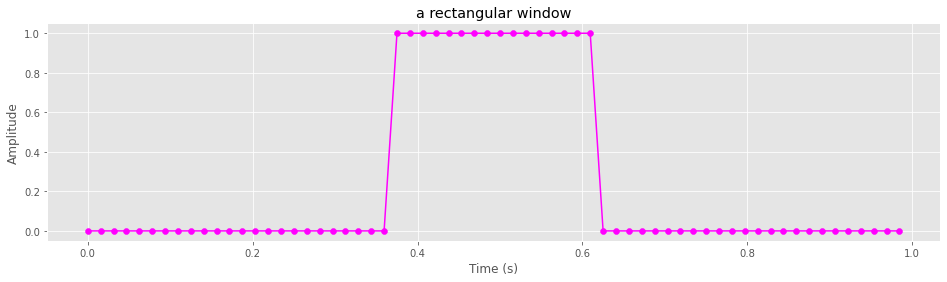

In [24]:
## Make rectangular window
N=64
K=16
f_s=64
start_index=24
end_index=start_index+K

x_rect, time_steps = gen_rect_window(start_index=start_index, end_index=end_index, sample_rate=f_s, seq_length=N)

fig, timedom = plt.subplots(figsize=(16, 4))
timedom.scatter(time_steps, x_rect, color='magenta')
timedom.plot(time_steps, x_rect, color='magenta')
timedom.set_xlabel('Time (s)')
timedom.set_ylabel('Amplitude')
timedom.set_title('a rectangular window')

You should see a sequence with 64 point where the mmiddle 16 points have value 1 and the rest have value 0  (i.e., it looks like a rectangle in the middle).

### Now, let's  look at the frequency response of the rectangular window

Text(0.5, 1.0, 'Frequency response of rectangular window')

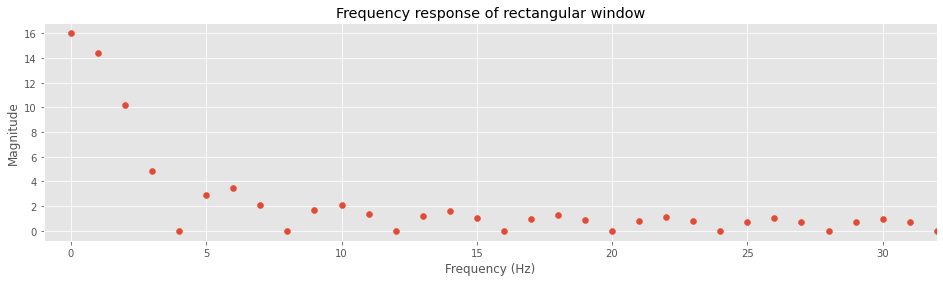

In [25]:
## Now we do the DFT on the rectangular function:

## get the magnitudes and phases
mags_rect, phases_rect = get_dft_mag_phase(x_rect, N)

## the DFT output frequencies
dft_freqs_rect = get_dft_freqs_all(f_s, N)

## let's just look at the magnitudes
fig, fdom = plt.subplots(figsize=(16, 4))
fdom.set(xlim=(-1, N/2))
fdom.scatter(dft_freqs_rect, mags_rect)
fdom.set_xlabel("Frequency (Hz)")
fdom.set_ylabel('Magnitude')
fdom.set_title('Frequency response of rectangular window')
## Looks leaky! 

### Leaky windows? 

The plot of the frequency magnitude response of our rectangular window has the hallmarks of leakiness. That is, the frequency response looks scalloped, with the biggest peak occuring around 0Hz. That is, it looks like a low pass filter!  

With a bit of algebra we can derive the frequency for any $m$ (not just the DFT output bins indices) to be the following:  

If $x[n]$ is a rectangular function of N samples with $K$ continugous samples of value 1 (starting at index $n_0$), we can figure out what the DFT output will be:

$$X[m] = e^{i(2\pi m/N)(n_0-(K-1)/2)} . \frac{\sin(2\pi mK/2N)}{\sin(2\pi m /2N)}$$

This is called the **Dirichlet kernel**. It has the **sinc** shape we saw when we looked at spectral leakage. 

How is this useful?  Since we know what the frequency response of a rectangular window is, we know what convolving this with different input sequences will look like in the frequency domain.  We just multiply the frequency magnitude responses together. 

<div class="alert alert-warning">
On a more general note, this sort of convolution with a (short) window is how we do frequency analysis of speech: we taking windows of speech (aka frames) through time and and apply the DFT to get a frequency response.  A rectangular window is the simplest type of window we can take.  The equation above tells us that the sinc shaped response is an inherent part of using this sort of window.  In fact, we can use other window types (e.g. Hanning) to make the main lobes shaper and the sidelobes flatter, but we never really get away from this sinc shape in real world applications.  This is a key component of this soft of <strong>short term analysis</strong>.  

  </div>

Let's write this up in a function: 

In [26]:
def gen_rect_response(n_0, K, N, stepsize=0.01, polar=True, amplitude=1):
    ms = np.arange(0.01, N, stepsize)
    qs = 2*np.pi*ms/N 

    ## Infact, we can work the frequency response to be the Dirichlet Kernel:
    response = (np.exp(-1j*qs*(n_0-(K-1)/2)) * np.sin(qs*K/2))/np.sin(qs/2) 
    
    if polar: 
        response_polar = [cmath.polar(z) for z in response]
        mags = np.array([m for m, _ in response_polar]) * amplitude
        phases = np.array([ph if round(mag) > 0 else 0 for mag, ph in response_polar])
        return (mags, phases, ms)
        
    return response, ms
    

Now we can plot the dirichlet kernel with the leaky looking DFT magnitudes we calculated earlier for our rectangular window.  

Text(0.5, 1.0, 'Frequency response of a rectangular sequence, 64 samples with 16 contiguous ones')

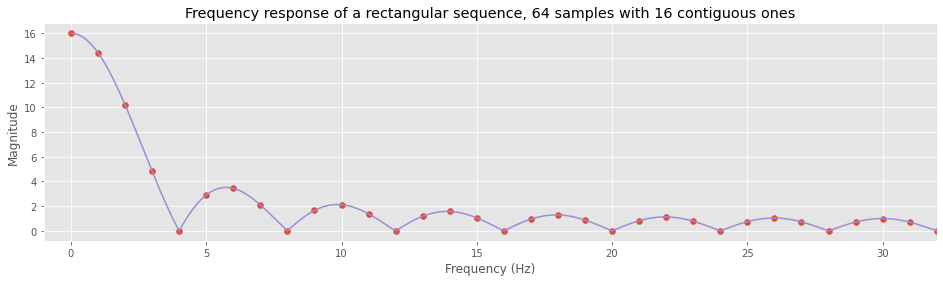

In [27]:
## Overlay the dirichlet kernel onto the DFT magnitudes we calculated earlier
## You should be able to see that the DFT magnitudes appear as discrete samples of the Dirichlet Kernel

mags_rect, phases_rect = get_dft_mag_phase(x_rect, N)
mags_rect_sinc , _ , ms = response = gen_rect_response(start_index, K, N)

fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(dft_freqs_rect, mags_rect, label='rectangular window')
ax.plot((f_s/N)*ms, mags_rect_sinc, color='C2', label='dirichlet')
ax.set(xlim=(-1,N/2))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('Frequency response of a rectangular sequence, %d samples with %d contiguous ones' % (N, K))

You should be able to see that the DFT magnitudes appear as discrete samples of the sinc shaped Dirichlet Kernel




### The unweighted average filter as a rectangular function

We can think of our 5-point unweighted average filter as a 5-point input sequence with all values set to 1/5.  We can then deduce that the frequency response of the filter will have the same shape as the frequency response of a rectangular window of all ones, but scaled down by 1/5.  

Now let's check: 

h_avg: [0.2 0.2 0.2 0.2 0.2]


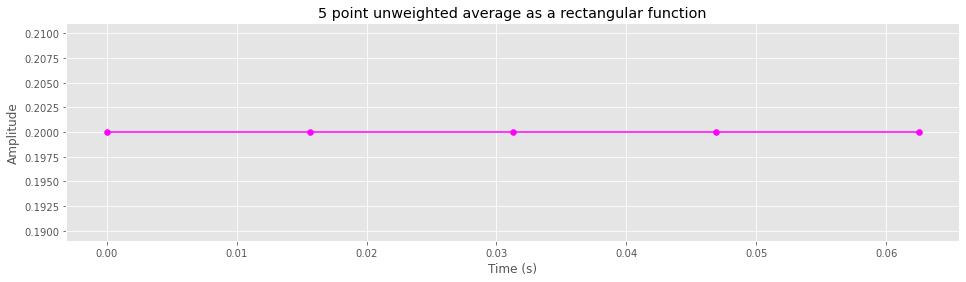

In [28]:
N_h=5 
f_s=64
start_index=0
end_index=N_h - start_index

## A 5 point rectangular window of all ones
h_avg, time_steps = gen_rect_window(start_index=start_index, end_index=end_index, sample_rate=f_s, seq_length=N_h)
h_avg = h_avg/N_h

fig, td = plt.subplots(figsize=(16, 4))
td.scatter(time_steps, h_avg, color='magenta')
td.plot(time_steps, h_avg, color='magenta')
td.set_xlabel('Time (s)')
td.set_ylabel('Amplitude')
td.set_title('5 point unweighted average as a rectangular function')

## Not very exciting looking! 
print("h_avg:", h_avg)

You should just see 5 point in a row, all with value 1/5.  Now, we can plot the DFT magnitude response, as well as it's idealized continuous version: 

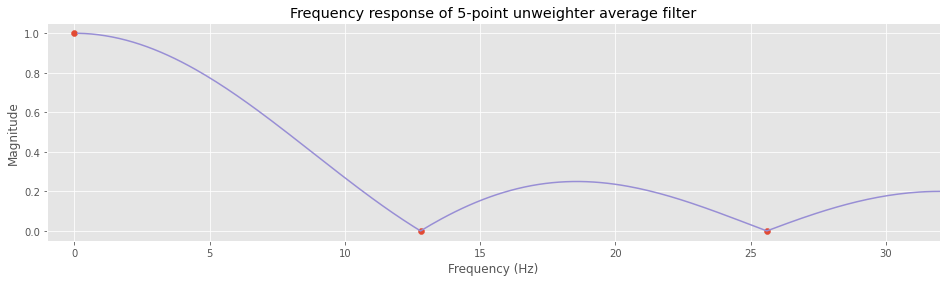

In [29]:
## Get the frequency magnitude response for our rectangular function
mags_h_avg, phases_h_avg = get_dft_mag_phase(h_avg, N_h)

## Get the continuous 
rect_mags_h_avg, _ , ms = gen_rect_response(start_index, N_h, N_h, amplitude=np.max(h_avg)) 


## x-axis as frequencies rather than indices
ms_freqs_h_avg = (f_s/N_h) * ms
dft_freqs_h_avg = (f_s/N_h) * np.arange(N_h)

## Plot the frequency magnitude response
fig, fd = plt.subplots(figsize=(16, 4))
fd.set(xlim=(-1, N/2))
fd.scatter(dft_freqs_h_avg, mags_h_avg)
fd.set_xlabel('Frequency (Hz)')
fd.set_ylabel('Magnitude')
fd.set_title('Frequency response of 5-point unweighter average filter')
#fd.scatter(dft_freqs_rect, mags_rect)

fd.plot(ms_freqs_h_avg, rect_mags_h_avg, color="C2")

You should see $floor(N/2) = 2$ points, with a main lobe peaking at 0 Hz, and side lobes peaking between each of the DFT output frequencies.  
So,  DFT frequencies sit exactly at the zeros of this function when the windown size K is the same as the number of samples. 


### Matching the filter and input size with zero padding

The theorem we saw above told us that we could calculate the frequency response of applying the FIR filter to an input sequence (via convolution), but multiply the DFT outputs of the filter and the input sequence.  

Now, the x-axis range matches our that of our noisy input sequence because that is determined by the sampling rate. However, the filter frequency response we have above only has 5 outputs, while our input sample size was 64 because the number of DFT outputs is determined by the number of samples we put into the DFT.  

To get things in the right form, we need to do some **zero padding** of the filter. We'll see that this basically gives us more samples of the Dirichlet Kernel corresponding to the filter frequency response. 



Text(0.5, 1.0, '5 point unweighted average FIR filter padded with zeros')

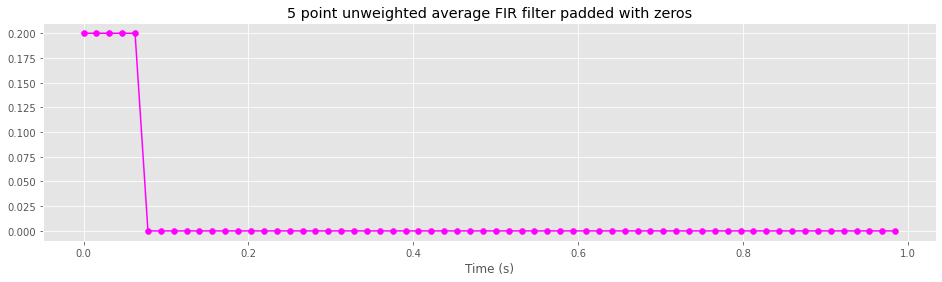

In [30]:
N=64
K=5
f_s=64
start_index=0
end_index=K

## Make a rectangular filter: K ones at the start
h_avg_pad, time_steps = gen_rect_window(start_index=start_index, end_index=end_index, sample_rate=f_s, seq_length=N)

## Divide by K to make it an average
h_avg_pad = h_avg_pad/K

## Plot the filter
fig, td = plt.subplots(figsize=(16, 4))
td.scatter(time_steps, h_avg_pad, color='magenta')
td.plot(time_steps, h_avg_pad, color='magenta')
td.set_xlabel('Time (s)')
td.set_title('5 point unweighted average FIR filter padded with zeros')

#print("N=%d, K=%d, start=%d, end=%d" % (N, K, start_index, end_index))




Text(0.5, 1.0, 'Magnitude response of 5-point unweighter average filter zero padded to 64 samples')

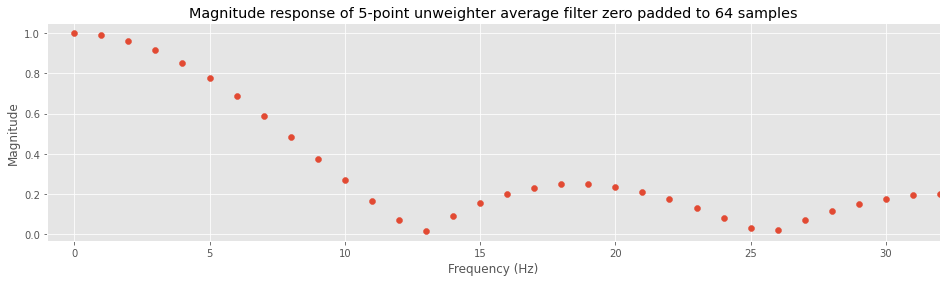

In [31]:
## Get the frequency magnitude response for our rectangular function
mags_havg, phases_havg = get_dft_mag_phase(h_avg_pad, N)

## Plot the frequency magnitude response 
## x-axis as actual frequencies rather that DFT indices
dft_freqs_havg = (f_s/N) * np.arange(N)

fig, fd = plt.subplots(figsize=(16, 4))
fd.set(xlim=(-1,N/2))
fd.scatter(dft_freqs_havg, mags_havg)
fd.set_xlabel('Frequency (Hz)')
fd.set_ylabel('Magnitude')
fd.set_title('Magnitude response of 5-point unweighter average filter zero padded to 64 samples')

You should be able to see more clearly in the frequency response graph that the zero padding doesn't change doesnt change the basic shape of the filter's frequency response, we just get a finer grained representation in terms of samples (red dots). 

### Calculate the input and filter frequency responses

In [32]:
## Now let's calculate frequency responses of the original input
mags, phases = get_dft_mag_phase(x_noisy, N)

## ...  the filter
mags_filter, phases_filter = get_dft_mag_phase(h_avg_pad, N)

## ... and the filtered output that we calculated above
mags_avg, phases_avg = get_dft_mag_phase(y_avg, N)

## Plot with actual frequencies on the x-axis
dft_freqs = get_dft_freqs_all(f_s, N)

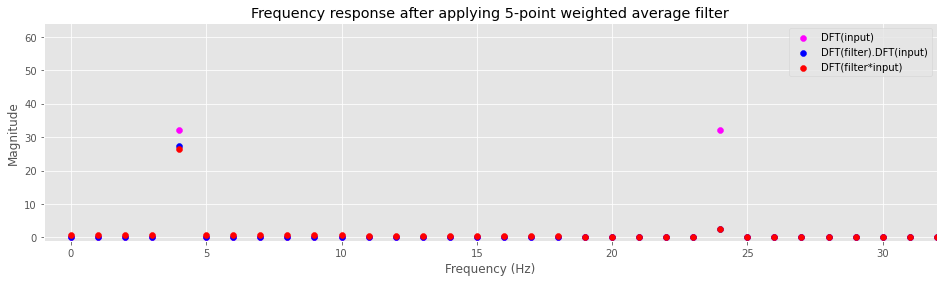

In [33]:
## plot frequency responses

fig, fd = plt.subplots(figsize=(16, 4))
fd.set(xlim=(-1,N/2), ylim=(-1, N))

# DFT(input)
fd.scatter(dft_freqs, mags, color='magenta', label='DFT(input)')

# DFT(filter) * DFT(input)
fd.scatter(dft_freqs, mags_filter*mags, color='blue', label='DFT(filter).DFT(input)')

# DFT(filtered input)
fd.scatter(dft_freqs, mags_avg, color='red', label='DFT(filter*input)')
fd.set_xlabel('Frequency (Hz)')
fd.set_ylabel('Magnitude')
fd.set_title('Frequency response after applying 5-point weighted average filter')
fd.legend()

You should see that the results from multiplying the DFT magnitudes from the input and the filter (blue) is (more or less) the same as the DFT of applying the filter in th time domain via convolution (red)

* Notice that there are some differences between the results from the time domain application of the filter (red) and the frequency domain multiplication (blue).  In particular there appears to be some leakage in the time-domain convolution case, possibly due to floating point errors.

### Exercise

* Try changing the frequency of the second cosine component of our compound wave in the code below. 
    * Does the amount of attenuation of the high frequency component change as suggested by the DFT of the filter? 
    * e.g. try 26 Hz vs 19 Hz
* What does this tell you about how well this low pass filter get's rid of high frequency noise?



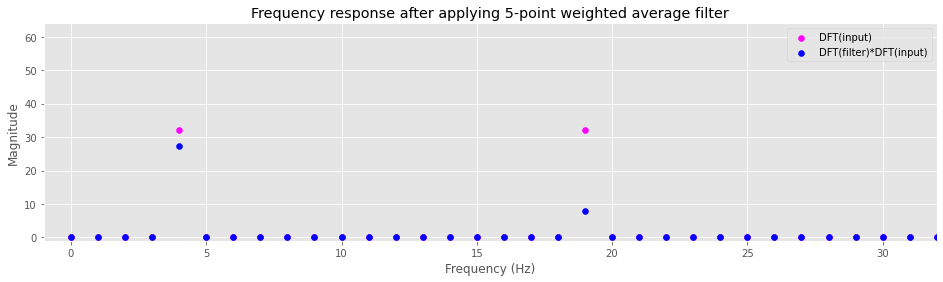

In [34]:
## Change the frequency of x2

x1, time_steps = gen_sinusoid(frequency=4, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)
x2, time_steps = gen_sinusoid(frequency=19, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)

# add them up!
x_noisy = x1 + x2

## Now let's calculate frequency responses of the original input
mags, phases = get_dft_mag_phase(x_noisy, N)

## ...  the filter
mags_filter, phases_filter = get_dft_mag_phase(h_avg_pad, N)

## Plot with actual frequencies on the x-axis
dft_freqs = get_dft_freqs_all(f_s, N)

## plot frequency responses

fig, fd = plt.subplots(figsize=(16, 4))

fd.set(xlim=(-1,N/2), ylim=(-1, N))


# DFT(input)
fd.scatter(dft_freqs, mags, color='magenta', label='DFT(input)')

# DFT(filter) * DFT(input)
fd.scatter(dft_freqs, mags_filter*mags, color='blue', label='DFT(filter)*DFT(input)')

fd.set_xlabel('Frequency (Hz)')
fd.set_ylabel('Magnitude')
fd.set_title('Frequency response after applying 5-point weighted average filter')
fd.legend()

### Notes